In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import pynsitu as pyn
import lib as lib
from lib import KEYS, raw_dir
import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import (
    synthetic_traj,
    noise_irregular_sampling,
    ref_case,
    typical_case,
    negpos_spectra,
)

/Users/mdemol/opt/anaconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/mdemol/opt/anaconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
N = 10
position_noise = 20
ntype = "white_noise"
offset_type = "svp_scripps_10"
dt_smooth = "2h"
print(ref_case)

{'T': 5, 'U_low': 0.3, 'U_ni': 0.2, 'U_2': 0, 'U_1': 0, 'tau_eta': 0.1, 'n_layers': 5}


In [3]:
DF = dict()

# TRUE
t = (
    np.arange(0, 50 * 24 * 60, 60) / 60 / 24
)  # use it instead of (50, 1/24/60 because otherwise not regularly sampled
dst = synthetic_traj(t, N, **ref_case)  # u,v, ax, ay computed
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

# OBSERVED

dso = noise_irregular_sampling(
    dst, t, position_noise, ntype=ntype, offset_type=offset_type
)
dfo = st.dataset2dataframe(dso).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")

DF["Observed"] = dfo

# Interpolated True
dsti = dst.interp(time=pd.date_range(dfo.index.min(), dfo.index.max(), freq=dt_smooth))
dsti["dt"] = dsti.time.diff("time") / pd.Timedelta("1s")
dfti = st.dataset2dataframe(dsti).rename(columns={"draw": "id"})

DF["True_" + dt_smooth] = dfti

13674


In [4]:
acc_cut = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]  # enp.linspace(1e-6, 1e-3, 10)
DF0 = DF.copy()

In [5]:
# SMOOTHED
for accc in acc_cut:
    dfv = pyn.drifters.smooth_all(
        dfo,
        "variational",
        dt_smooth,
        parameters=dict(
            acc_cut=accc,
            position_error=position_noise,
            acceleration_amplitude=1.9e-5,
            acceleration_T=5,
            acc_cut_key=("ax", "ay", "Axy"),
        ),
        geo=False,
    )
    DF0[f"acc_cut ={accc}"] = dfv
DF0.keys()

874 single spikes dropped out of 3649 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
938 single spikes dropped out of 3647 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
933 single spikes dropped out of 3649 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
894 single spikes dropped out of 3649 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
901 single spikes dropped out of 3646 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
972 single spikes dropped out of 3649 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
940 single spikes dropped out of 3650 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
761 single spikes dropped out of 3648 potential ones (acceleration threshold)
Chunking dataframe into 2 days chunks
939 single spikes dropped out of 3650 potential ones (acceleration thres

dict_keys(['True_1min', 'Observed', 'True_2h', 'acc_cut =1e-06', 'acc_cut =5e-06', 'acc_cut =1e-05', 'acc_cut =5e-05', 'acc_cut =0.0001', 'acc_cut =0.0005', 'acc_cut =0.001'])

In [15]:
def diagnostics(DF, param_name, num, true_key="True_2h", d=0):

    # ms of the diff
    dfms = st.ms_diff(DF, true_key)
    dfms = dfms[dfms.index != true_key]
    n = len(dfms)
    if num:
        dfms[param_name] = [float(v.split("=")[-1]) for v in dfms.index]
        dfms = dfms.reset_index().set_index(param_name)
        fig, axs = plt.subplots(3, 3, sharex=True, figsize=(8, 5))
        i = 0
        axs = axs.flatten()
        for var in ["x", "y", "X", "u", "v", "U", "ax", "ay", "Axy"]:
            ax = axs[i]
            dfms[var].plot(ax=ax, color="teal", marker="+")
            ax.grid()
            i += 1
            ax.set_ylabel(rf"$\langle ({var}-{var}_t)^2 \rangle $")
        fig.suptitle(
            rf"$\langle (\alpha-\alpha_t)^2 \rangle $ depending on " + param_name
        )
        fig.tight_layout()

        fig1, axs = plt.subplots(3, 3, sharex=True, figsize=(8, 5))
        i = 0
        axs = axs.flatten()
        for var in ["x", "y", "X", "u", "v", "U", "ax", "ay", "Axy"]:
            ax = axs[i]
            dfms["ratio_" + var].plot(ax=ax, color="teal", marker="+")
            ax.grid()
            i += 1
            ax.set_ylabel(
                rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle $"
            )
        fig1.suptitle(
            rf"$\langle (\alpha-\alpha_t)^2 \rangle/ \langle \alpha_t^2 \rangle $ depending on "
            + param_name
        )
        fig1.tight_layout()

    else:
        fig, axs = plt.subplots(3, 2, sharey=True, figsize=(8, n))
        i = 0
        axs = axs.flatten()
        for var in ["x", "y", "u", "v", "ax", "ay" "X", "U", "Axy"]:
            ax = axs[i]
            dfms[var].plot.barh(ax=ax, color="teal", width=0.8)
            ax.grid()
            ax.set_xlim(-0.1 * dfms[var].max(), dfms[var].max() * 1.5)
            i += 1
            ax.set_xlabel(rf"$\langle ({var}-{var}_t)^2 \rangle$")
            ax.bar_label(
                ax.containers[0],
                labels=[
                    np.format_float_scientific(l, precision=4, exp_digits=2)
                    for l in dfms[var].values
                ],
            )

        fig.suptitle(rf"$\langle (\alpha-\alpha_t)^2 \rangle $")
        fig.tight_layout()

        fig1, axs = plt.subplots(3, 2, sharey=True, figsize=(8, n))
        i = 0
        axs = axs.flatten()
        for var in ["x", "y", "u", "v", "ax", "ay" "X", "U", "Axy"]:
            ax = axs[i]
            dfms["ratio_" + var].plot.barh(ax=ax, color="teal", width=0.8)
            ax.grid()
            ax.set_xlim(
                -0.1 * dfms["ratio_" + var].max(), dfms["ratio_" + var].max() * 1.5
            )
            i += 1
            ax.set_xlabel(
                rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle $"
            )
            ax.bar_label(
                ax.containers[0],
                labels=[
                    np.format_float_scientific(l, precision=4, exp_digits=2)
                    for l in dfms["ratio_" + var].values
                ],
            )
        fig1.suptitle(
            rf"$\langle (\alpha-\alpha_t)^2 \rangle/ \langle \alpha_t^2 \rangle $"
        )
        fig1.tight_layout()

    # diff of the ms
    dfmsd = st.diff_ms(DF, true_key)
    dfmsd = dfmsd[dfmsd.index != true_key]
    nd = len(dfmsd)

    fig2, axs = plt.subplots(3, 2, sharey=True, figsize=(8, nd))
    i = 0
    axs = axs.flatten()
    for var in ["x", "y", "u", "v", "ax", "ay"]:
        ax = axs[i]
        dfmsd[var].plot.barh(ax=ax, color="teal", width=0.8)
        ax.grid()
        ax.set_xlim(-0.1 * dfmsd[var].max(), dfmsd[var].max() * 1.5)
        i += 1
        ax.set_xlabel(rf"$\langle ({var}-{var}_t)^2 \rangle$")
        ax.bar_label(
            ax.containers[0],
            labels=[
                np.format_float_scientific(l, precision=4, exp_digits=2)
                for l in dfmsd[var].values
            ],
        )
    fig2.suptitle(rf"$\langle (\alpha-\alpha_t)^2 \rangle$")
    fig2.tight_layout()

    fig3, axs = plt.subplots(3, 2, sharey=True, figsize=(8, nd))
    i = 0
    axs = axs.flatten()
    for var in ["x", "y", "u", "v", "ax", "ay"]:
        ax = axs[i]
        dfmsd["ratio_" + var].plot.barh(ax=ax, color="teal", width=0.8)
        ax.grid()
        ax.set_xlim(
            -0.1 * dfmsd["ratio_" + var].max(), dfmsd["ratio_" + var].max() * 1.5
        )
        i += 1
        ax.set_xlabel(
            rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle $"
        )
        ax.bar_label(
            ax.containers[0],
            labels=[
                np.format_float_scientific(l, precision=4, exp_digits=2)
                for l in dfmsd["ratio_" + var].values
            ],
        )
    fig3.suptitle(
        rf"$\langle (\alpha-\alpha_t)^2 \rangle / \langle \alpha_t^2 \rangle$"
    )
    fig3.tight_layout()

    # RATIO OF MS
    dfra = st.ratio_ms(DF, true_key)
    fig9, axs = plt.subplots(3, 2, sharey=True, figsize=(8, nd))
    i = 0
    axs = axs.flatten()
    for var in ["x", "y", "u", "v", "ax", "ay"]:
        ax = axs[i]
        dfra[var].plot.barh(ax=ax, color="teal", width=0.8)
        ax.axvline(1, ls="--", color="r")
        ax.grid()
        ax.set_xlim(-0.1 * dfra[var].max(), dfra[var].max() * 1.5)
        i += 1
        ax.set_xlabel(rf"$\langle {var}^2 \rangle /\langle {var}_t^2 \rangle$")
        ax.bar_label(
            ax.containers[0],
            labels=[
                np.format_float_scientific(l, precision=4, exp_digits=2)
                for l in dfra[var].values
            ],
        )
    fig9.suptitle(rf"$\langle \alpha^2 \rangle /\langle \alpha_t^2 \rangle$")
    fig9.tight_layout()

    # SPECTRA
    DSE = st.spectrum_DF(DF)
    dse = st.DSE2dse(DSE)
    dsen = sum(st.negpos_spectra(dse))
    fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

    for l in dsen.Trajectory:
        dsen.x_y.mean("id").plot(hue="Trajectory", ax=axs[0], add_legend=True)
        dsen.u_v.mean("id").plot(hue="Trajectory", ax=axs[1], add_legend=False)
        dsen.ax_ay.mean("id").plot(hue="Trajectory", ax=axs[2], add_legend=False)
    for ax in axs:
        ax.grid()
        ax.set_xscale("log")
        ax.set_yscale("log")
    fig4.suptitle("PSD")
    fig4.tight_layout()

    # SPECTRA OF THE DIFF
    DF_diff = st.build_DF_diff(DF, true_key)
    DSE_d = st.spectrum_DF(DF_diff)
    dse_d = st.DSE2dse(DSE_d)
    dsen_d = sum(st.negpos_spectra(dse_d))

    fig5, axs = plt.subplots(1, 3, figsize=(10, 5))

    for l in dsen.Trajectory:
        dsen_d.x_y.mean("id").plot(hue="Trajectory", ax=axs[0], add_legend=True)
        dsen_d.u_v.mean("id").plot(hue="Trajectory", ax=axs[1], add_legend=False)
        dsen_d.ax_ay.mean("id").plot(hue="Trajectory", ax=axs[2], add_legend=False)
    for ax in axs:
        ax.grid()
        ax.set_xscale("log")
        ax.set_yscale("log")
    fig5.suptitle("PSD of the difference")
    fig5.tight_layout()

    # INT PER BAND
    dsib = st.ds_int_band(dsen).mean("id")
    dfib = dsib.to_dataframe().dropna()

    fig6, axs = plt.subplots(3, 1, sharey=True, figsize=(8, n))
    i = 0
    axs = axs.flatten()
    for var in ["bf_x_y", "ni_x_y", "hf_x_y"]:
        ax = axs[i]
        dfib[var].plot.barh(ax=ax, color="teal", width=0.8)
        ax.bar_label(
            ax.containers[0],
            labels=[
                np.format_float_scientific(l, precision=4, exp_digits=2)
                for l in dfib[var].values
            ],
        )
        ax.grid()
        ax.set_xlim(-0.1 * dfib[var].max(), dfib[var].max() * 1.5)
        ax.set_xlabel(var)
        i += 1
    axs[0].set_xlabel("BF")
    axs[1].set_xlabel("NI")
    axs[2].set_xlabel("HF")
    fig6.suptitle("Integration per band on postion (x,y) PSD")
    fig6.tight_layout()

    fig7, axs = plt.subplots(3, 1, sharey=True, figsize=(8, n))
    i = 0
    axs = axs.flatten()
    for var in ["bf_u_v", "ni_u_v", "hf_u_v"]:
        ax = axs[i]
        dfib[var].plot.barh(ax=ax, color="teal", width=0.8)
        ax.bar_label(
            ax.containers[0],
            labels=[
                np.format_float_scientific(l, precision=4, exp_digits=2)
                for l in dfib[var].values
            ],
        )
        ax.grid()
        ax.set_xlim(-0.1 * dfib[var].max(), dfib[var].max() * 1.5)
        ax.set_xlabel(var)
        i += 1
    axs[0].set_xlabel("BF")
    axs[1].set_xlabel("NI")
    axs[2].set_xlabel("HF")
    fig7.suptitle("Integration per band on velocities (u,v) PSD")
    fig7.tight_layout()

    fig8, axs = plt.subplots(3, 1, sharey=True, figsize=(8, n))
    i = 0
    axs = axs.flatten()
    for var in ["bf_ax_ay", "ni_ax_ay", "hf_ax_ay"]:
        ax = axs[i]
        dfib[var].plot.barh(ax=ax, color="teal", width=0.8)
        ax.bar_label(
            ax.containers[0],
            labels=[
                np.format_float_scientific(l, precision=4, exp_digits=2)
                for l in dfib[var].values
            ],
        )
        ax.grid()
        ax.set_xlim(-0.1 * dfib[var].max(), dfib[var].max() * 1.5)
        ax.set_xlabel(var)
        i += 1
    axs[0].set_xlabel("BF")
    axs[1].set_xlabel("NI")
    axs[2].set_xlabel("HF")
    fig8.suptitle("Integration per band on acceleration (ax,ay) PSD")
    fig8.tight_layout()

    return (
        dfms,
        dfmsd,
        dfra,
        dse,
        dse_d,
        dfib,
        fig,
        fig1,
        fig2,
        fig3,
        fig9,
        fig4,
        fig5,
        fig6,
        fig7,
        fig8,
    )

True_1min has not the same time index
Observed has not the same time index
True_1min
True_2h
acc_cut =1e-06
acc_cut =5e-06
acc_cut =1e-05
acc_cut =5e-05
acc_cut =0.0001
acc_cut =0.0005
acc_cut =0.001
True_1min has not the same time index
Observed has not the same time index
acc_cut =1e-06
acc_cut =5e-06
acc_cut =1e-05
acc_cut =5e-05
acc_cut =0.0001
acc_cut =0.0005
acc_cut =0.001


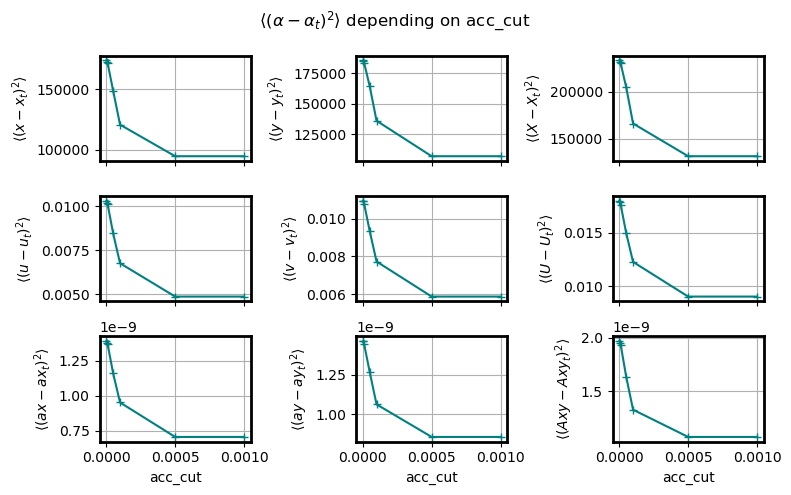

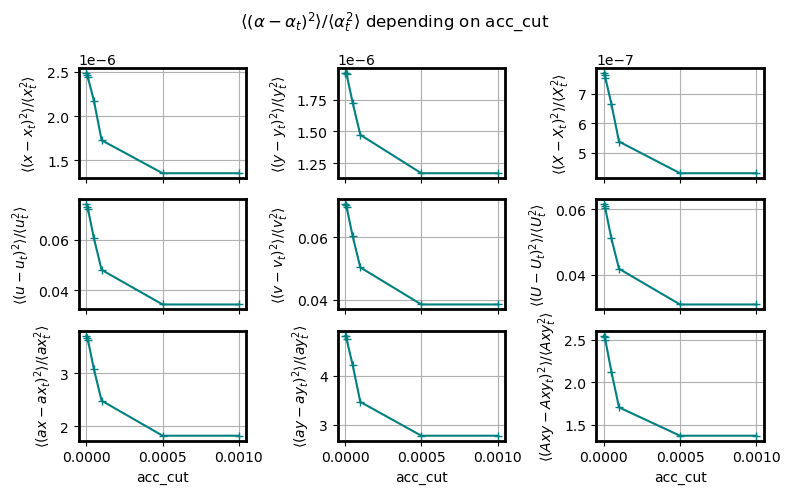

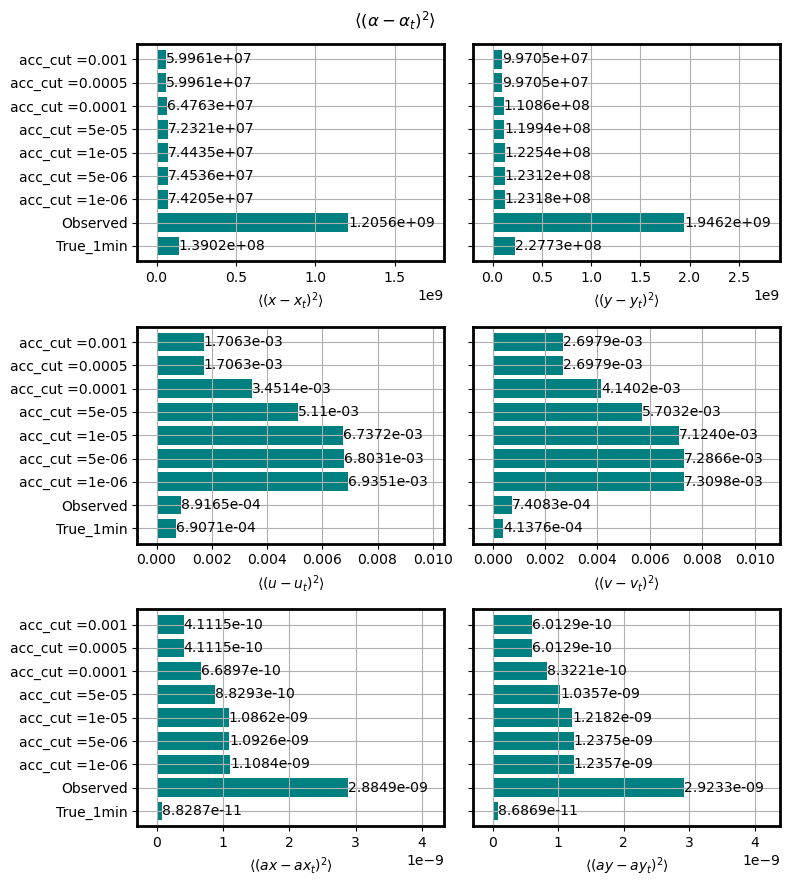

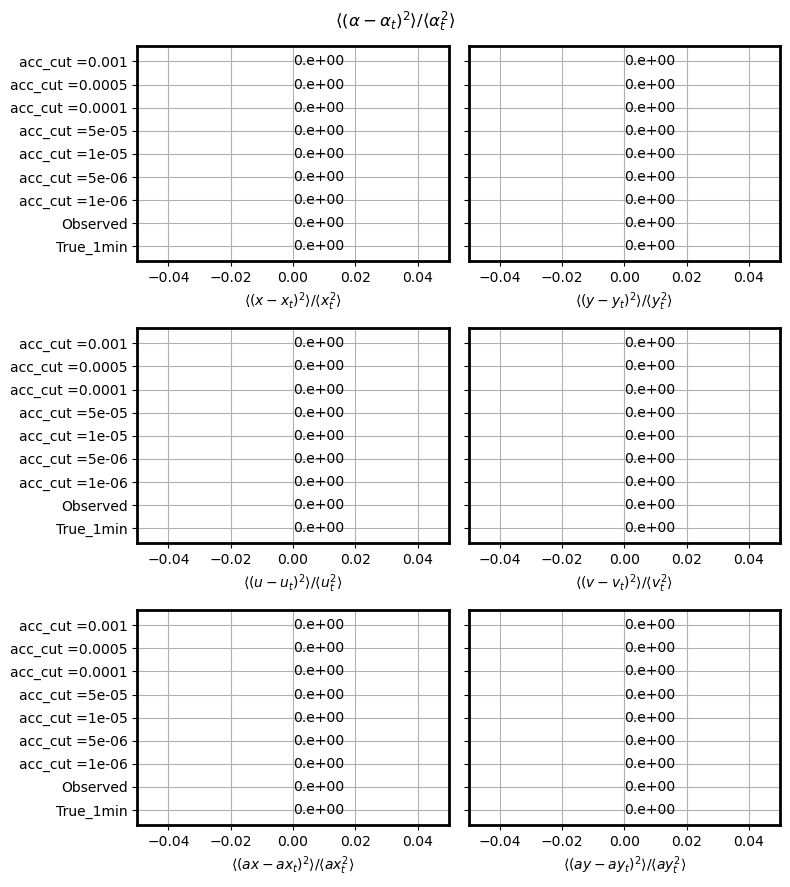

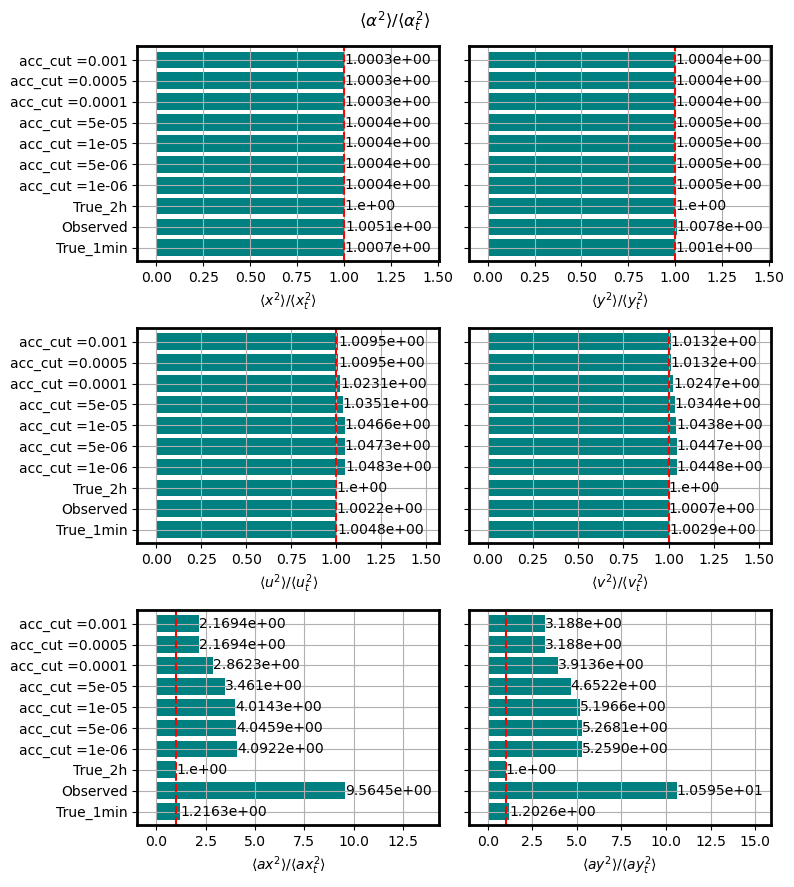

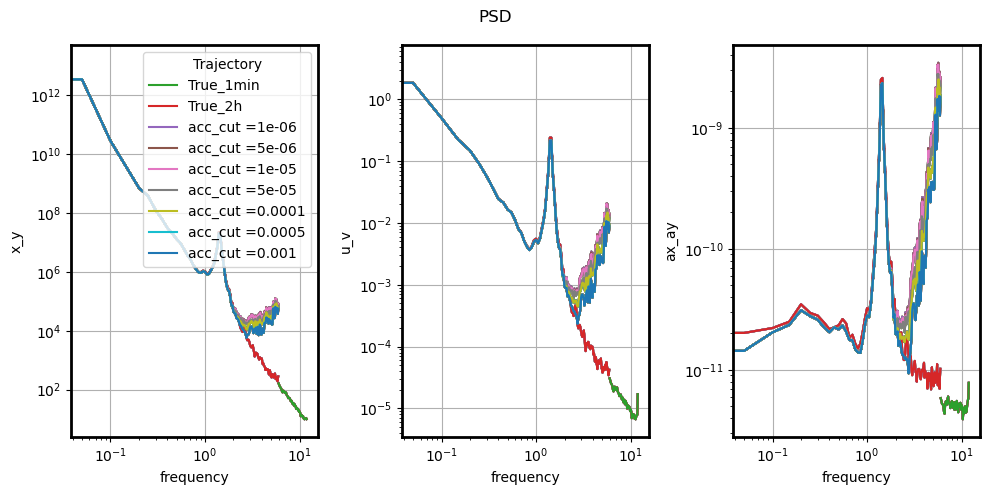

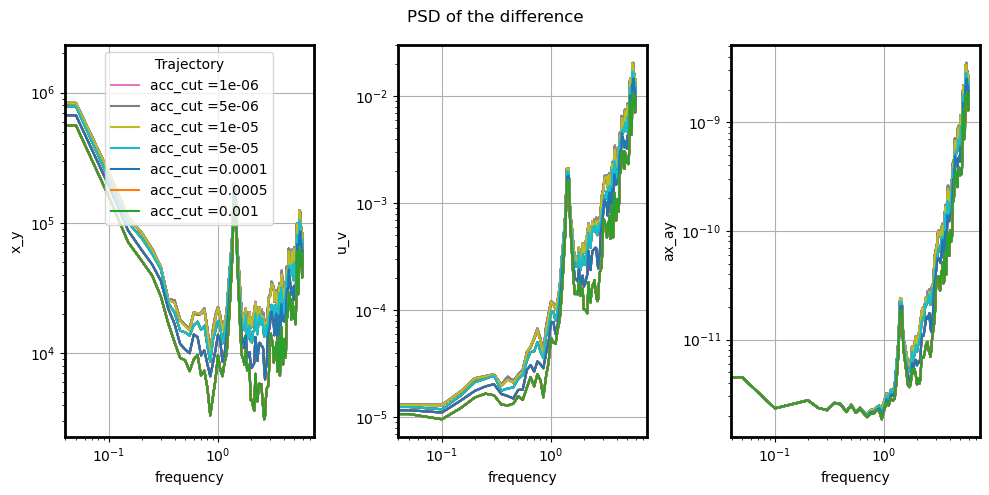

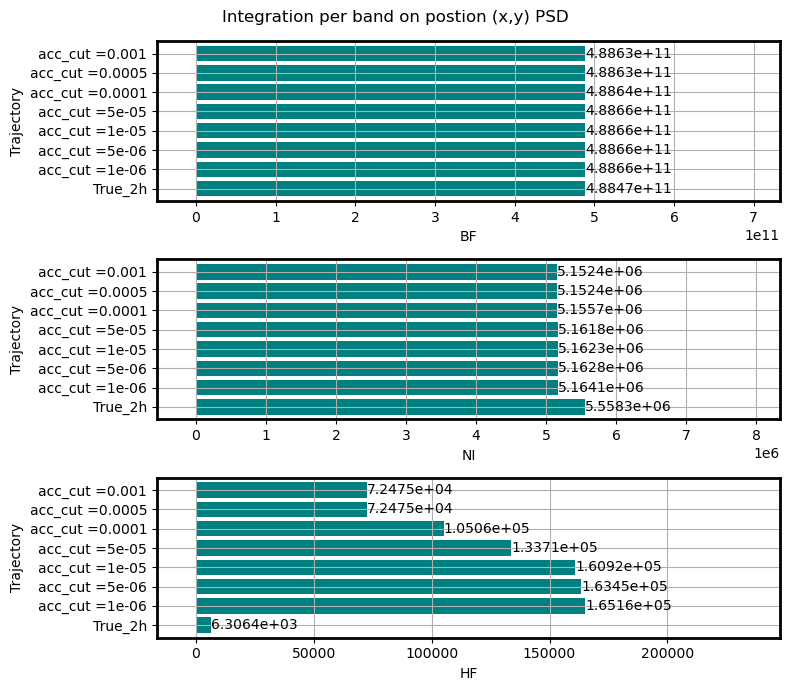

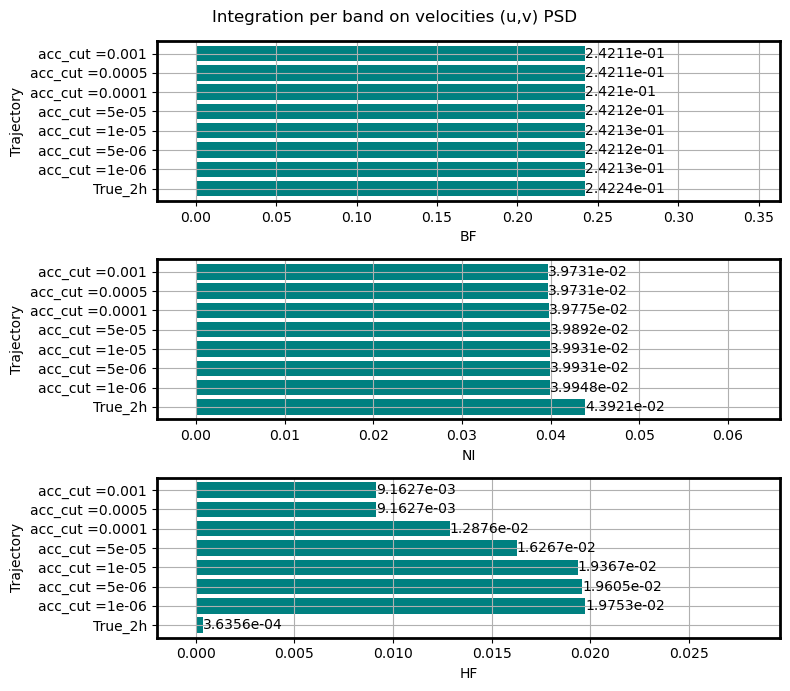

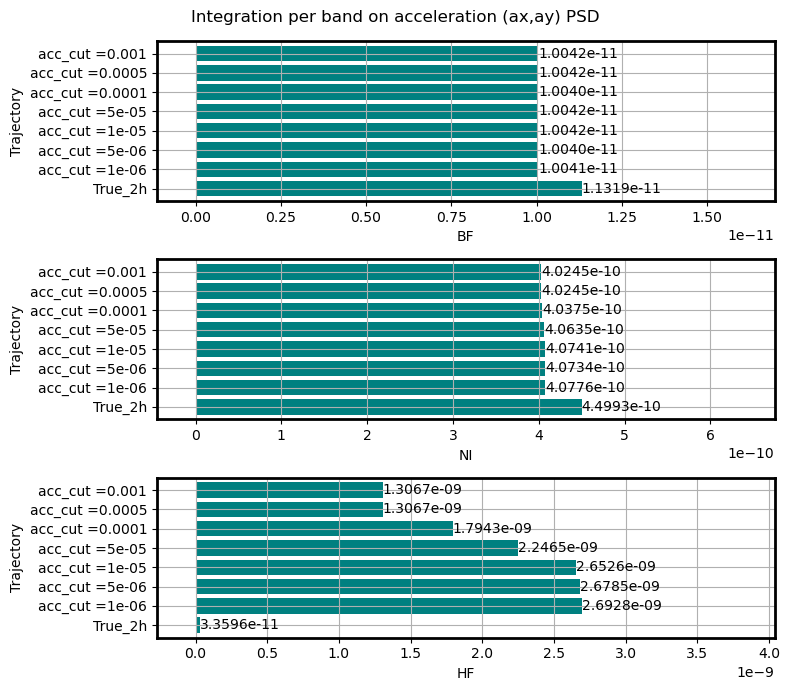

In [16]:
(
    dfms,
    dfmsd,
    dfra,
    dse,
    dse_d,
    dfib,
    fig,
    fig1,
    fig2,
    fig3,
    fig9,
    fig4,
    fig5,
    fig6,
    fig7,
    fig8,
) = diagnostics(DF0, num=True, param_name="acc_cut")